# Setup

## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import pickle
import shap
import os
from urllib.request import urlretrieve
from zipfile import ZipFile

# Crear clases

## Descargar Data

In [137]:
class descargarDataDeZipACSV:
    def __init__(self,url,zippath,csvpath):
        self.url = url
        self.zippath = zippath
        self.csvpath = csvpath
        self.descargarDeUrl()
        self.extraerDeZip()
        self.borrarZip()

    
    def descargarDeUrl(self):
        urlretrieve(self.url,self.zippath)

    def extraerDeZip(self):
        with ZipFile(self.zippath) as zObject: 
                zObject.extractall(path=self.csvpath)
    
    def borrarZip(self):
        os.remove(self.zippath)

# DEfinir clase de EDA

In [138]:
class EDA():

    @staticmethod
    def explorarDataFrame(df):
        print(f"Tamaño del dataset: {df.shape}")
        print("Tipos de datos por columna:")
        print(df.dtypes)
    
        print("Primeras filas:")
        print(df.head())
    
        print("Porcentaje de valores nulos por columna:")
        valores_nulos_porcentajes = df.isna().mean() * 100
        print(valores_nulos_porcentajes[valores_nulos_porcentajes > 0])

    @staticmethod
    def histogramasNumericas(df):
        cat_con = df.select_dtypes(include="number").columns.tolist()[1:]
        fig, axes = plt.subplots(4, 3, figsize=(50, 40))
        axes = axes.ravel()
        for col, ax in zip(df[cat_con], axes):
            sns.histplot(x=df[col], ax=ax, bins=30)
            ax.set(title=f'{col}', xlabel=None)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def boxPlotNumericas(df):
        cat_con = df.select_dtypes(include="number").columns.tolist()[1:]
        fig, axes = plt.subplots(4, 3, figsize=(50, 40))
        axes = axes.ravel()
        for col, ax in zip(df[cat_con], axes):
            sns.boxplot(x=df[col], ax=ax)
            ax.set(title=f'{col}', xlabel=None)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def countPlotCategoricas(df):
        cat_con = df.select_dtypes(include="object").columns.tolist()[1:]
        fig, axes = plt.subplots(3, 3, figsize=(50, 40))
        axes = axes.ravel()
        for col, ax in zip(df[cat_con], axes):
            sns.countplot(x=df[col], ax=ax)
            ax.set(title=f'{col}', xlabel=None)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def mapaDeCorrelacion(df,targetdf,target_col):
        df = pd.concat([df,targetdf],axis=1)
        numeric_df = df.select_dtypes(include=['number'])
        if target_col in df.columns:
            numeric_df[target_col] = df[target_col]
        corr = numeric_df.corr()
        plt.figure(figsize=(15, 10))
        sns.heatmap(corr, annot=True, cmap="BuGn", fmt='.2f')
        plt.title('Mapa de Calor de Correlación')
        plt.show()

    @staticmethod
    def boxPlotVSTarget(df,targetdf,target_col):
        df = pd.concat([df,targetdf],axis=1)
        cat_con = df.select_dtypes(include="number").columns.tolist()
        fig, axes = plt.subplots(2, 3, figsize=(50, 40))
        axes = axes.ravel()
        for col, ax in zip(cat_con, axes):
            sns.boxplot(data=df, x=col, y=target_col, ax=ax)
            ax.set(title=f'{col} vs {target_col}', xlabel=None)
        plt.tight_layout()
        plt.show()
    


## Clase para evaluar modelos

In [139]:
class evaluarModelo():

    @staticmethod
    def matriz_de_confuision(y,ypred,tipoDeSetDeDatos):
        # Matriz de confusión
        cm = confusion_matrix(y, ypred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Matriz de Confusión - Conjunto de {tipoDeSetDeDatos}")
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.show()

    @staticmethod
    def metricasDeRendimiento(y,ypred,tipoDeSetDeDatos):
        # Cálculo de métricas con zero_division
        precision = precision_score(y, ypred, average='weighted', zero_division=0)
        recall = recall_score(y, ypred, average='weighted', zero_division=0)
        f1 = f1_score(y, ypred, average='weighted', zero_division=0)

        # Mostrar resultados
        print(f"Precisión de conjunto de {tipoDeSetDeDatos}: {precision:.2f}")
        print(f"Recall de conjunto de {tipoDeSetDeDatos}: {recall:.2f}")
        print(f"Puntuación de conjunto de {tipoDeSetDeDatos}: {f1:.2f}")
    

    

## Clase para crear modelo

In [140]:
class cirrhosisModel():

    def __init__(self,preprocesspipelineX,model,param_grid,X_train,y_train,X_val,y_val):
        self.model = Pipeline([
            ('preprocesamiento', preprocesspipelineX),
            ('classifier', model)
        ])

        self.param_grid_logistico=param_grid
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def entrenar_modelo(self):
        grid_search = GridSearchCV(self.model, self.param_grid_logistico, cv=5, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)

        self.model = grid_search.best_estimator_


    def predecir_entrenamiento(self):
        self.y_pred = self.model.predict(self.X_train)

    def evaluar_modelo_con_entrenamiento(self):
        self.y_train_pred = self.model.predict(self.X_train)
        evaluarModelo.matriz_de_confuision(self.y_train,self.y_train_pred,"entrenamiento")
        evaluarModelo.metricasDeRendimiento(self.y_train,self.y_train_pred,"entrenamiento")

    def evaluar_modelo_con_validacion(self):
        print("Resultados validacion")
        self.y_val_pred = self.model.predict(self.X_val)
        evaluarModelo.matriz_de_confuision(self.y_val,self.y_val_pred,"validacion")
        evaluarModelo.metricasDeRendimiento(self.y_val,self.y_val_pred,"validacion")

## Modelos de cirrhosis

In [141]:
class modelosCIrrhosis:
    def __init__(self,csvpath):
        self.csvpath = csvpath
        self.crearPipelinePreprocesamientoX()
        self.crearPipelinePreprocesamientoy()

    def cargar_datos(self):
        self.datos = pd.read_csv(self.csvpath)
        EDA.explorarDataFrame(self.datos)

    def limpiar_datos(self):
        self.datos = self.datos.dropna(subset=['Drug'])
        

    def dividir_datos(self, test_size=0.3, validation_size=0.5):
        self.X = self.datos.drop(columns=["Status", 'ID'])
        self.y = self.datos["Status"]

        # División en entrenamiento (70%), validación (15%) y prueba (15%)
        self.X_train, X_test1, self.y_train, y_test1 = train_test_split(self.X, self.y, test_size=test_size, random_state=42, stratify=self.y)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(X_test1, y_test1, test_size=validation_size, random_state=42, stratify=y_test1)

        #Explorar los datos de entrenamiento
        EDA().boxPlotNumericas(self.X_train)
        EDA().histogramasNumericas(self.X_train)
        EDA().countPlotCategoricas(self.X_train)
        y_preprocesado_df = pd.DataFrame(
            self.pipelinePreprocesamientoy.fit_transform(self.y_train), 
            columns=["Status"],
            index=self.y_train.index
        )
        EDA().mapaDeCorrelacion(self.X_train,y_preprocesado_df,"Status")
        EDA().boxPlotVSTarget(self.X_train,self.y_train,"Status")
    
    def crearPipelinePreprocesamientoX(self):
        columnas_numericas_skew = ["Bilirubin", "Cholesterol", "Copper", "Alk_Phos", "SGOT", "Tryglicerides"]
        columnas_numericas_no_skew = ["N_Days", "Age", "Albumin", "Platelets", "Prothrombin"]
        columnas_categoricas = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
        pipeline_numerico_skew = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='median')),
            ('log_transform', FunctionTransformer(np.log1p, validate=False)),
            ('escalador', StandardScaler())
        ])
        pipeline_numerico_no_skew = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='median')),
            ('escalador', StandardScaler())
        ])
        pipeline_categorico = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='most_frequent')),
            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
        ])
        transformador_columnas = ColumnTransformer(transformers=[
            ('num_skew', pipeline_numerico_skew, columnas_numericas_skew),
            ('num_no_skew', pipeline_numerico_no_skew, columnas_numericas_no_skew),
            ('cat', pipeline_categorico, columnas_categoricas)
        ], remainder='passthrough')

        self.pipelinePreprocesamientoX=transformador_columnas

    def crearPipelinePreprocesamientoy(self):
        label_encoder = LabelEncoder()
        self.pipelinePreprocesamientoy = label_encoder

    def modeloRlog(self):
        modelo_logistico = LogisticRegression(max_iter=5000)
        param_grid_logistico = {
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['saga'],
            'classifier__l1_ratio': [0, 0.5, 1]  # Sólo para elasticnet
        }
        modelo = cirrhosisModel(self.pipelinePreprocesamientoX,
                                modelo_logistico,
                                param_grid_logistico,
                                self.X_train,
                                self.pipelinePreprocesamientoy.transform(self.y_train),
                                self.X_val,
                                self.pipelinePreprocesamientoy.transform(self.y_val))
        modelo.entrenar_modelo()
        modelo.evaluar_modelo_con_entrenamiento()
        modelo.evaluar_modelo_con_validacion()

        #To DO explicar modelo refactorizacion de shap


    def modeloXGboost(self):
        modelo_xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        param_grid_xgboost = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0]
    }
        modelo = cirrhosisModel(self.pipelinePreprocesamientoX,
                                modelo_xgboost,
                                param_grid_xgboost,
                                self.X_train,
                                self.pipelinePreprocesamientoy.transform(self.y_train),
                                self.X_val,
                                self.pipelinePreprocesamientoy.transform(self.y_val))
        modelo.entrenar_modelo()
        modelo.evaluar_modelo_con_entrenamiento()
        modelo.evaluar_modelo_con_validacion()

        #To DO explicar modelo refactorizacion de shap

    def modelos(self):
        self.modeloRlog()
        self.modeloXGboost()

Tamaño del dataset: (418, 20)
Tipos de datos por columna:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object
Primeras filas:
   ID  N_Days Status             Drug    Age Sex Ascites Hepatomegaly Spiders  \
0   1     400      D  D-penicillamine  21464   F       Y            Y       Y   
1   2    4500      C  D-penicillamine  20617   F       N            Y       Y   
2   3    1012      D  D-penicillamine  25594   M       N            N       N   
3   4    1925      D  D-penicillamine  19994   F       N            Y       Y   
4   5  

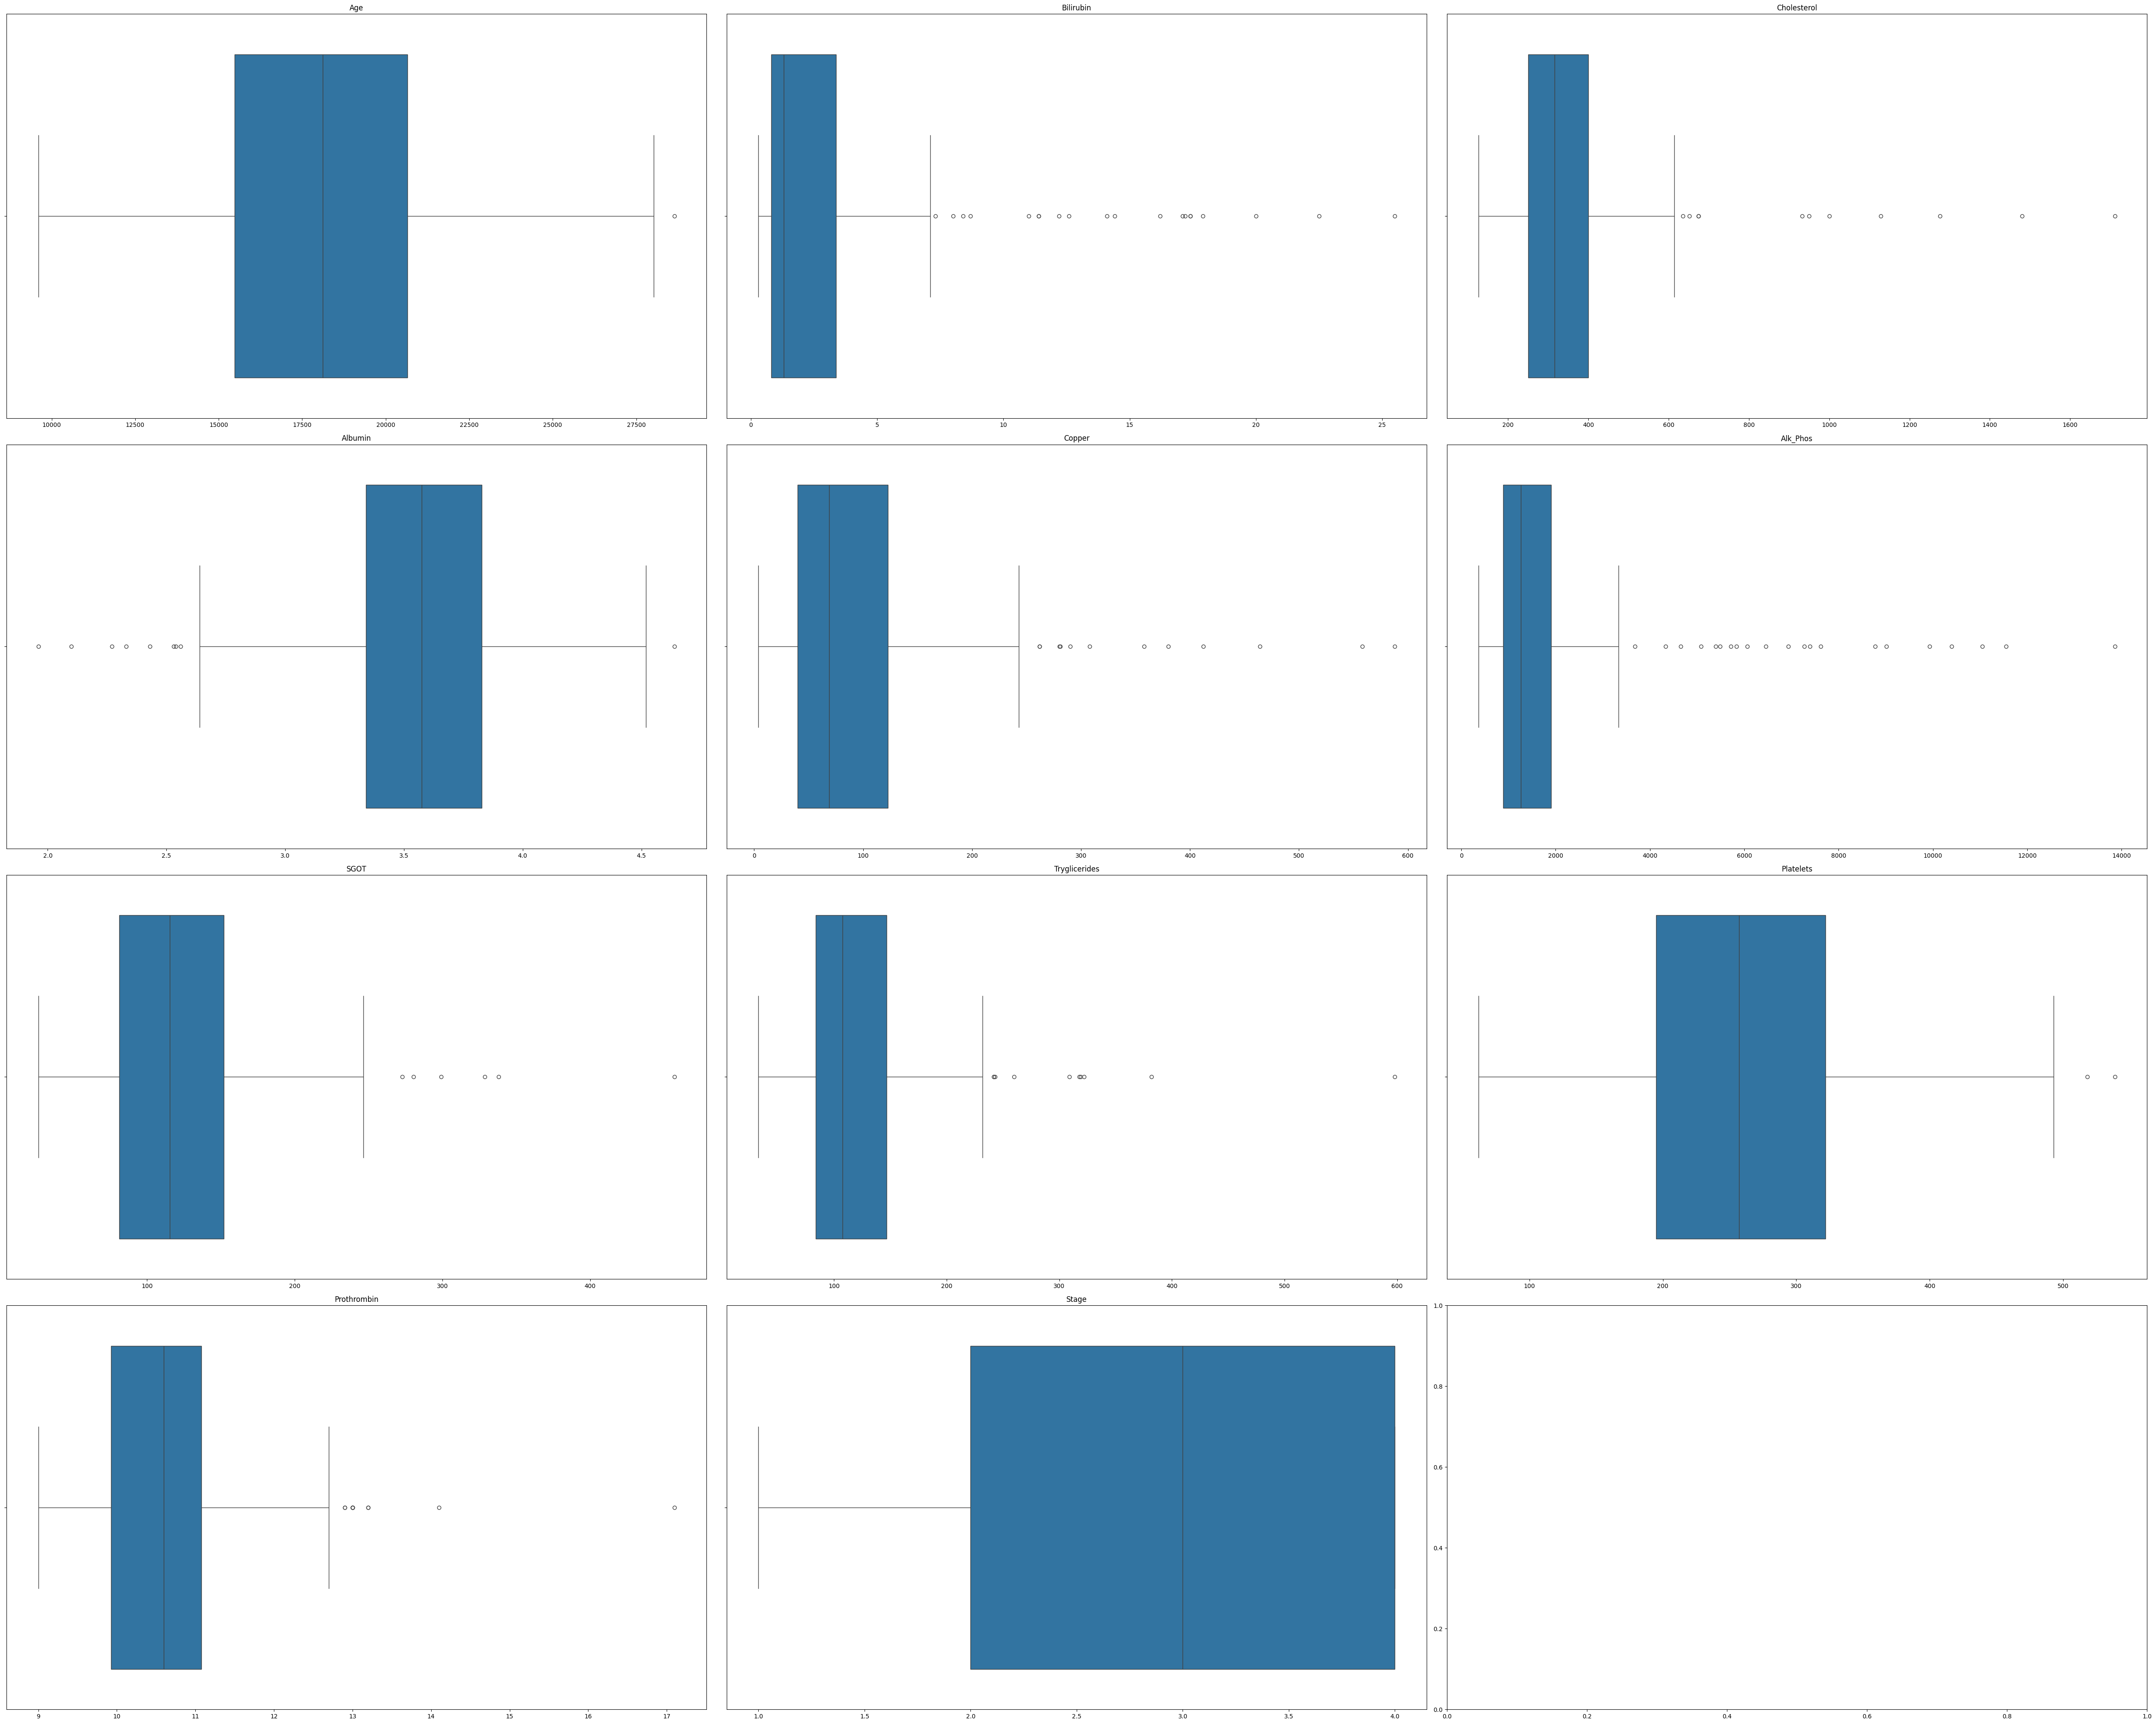

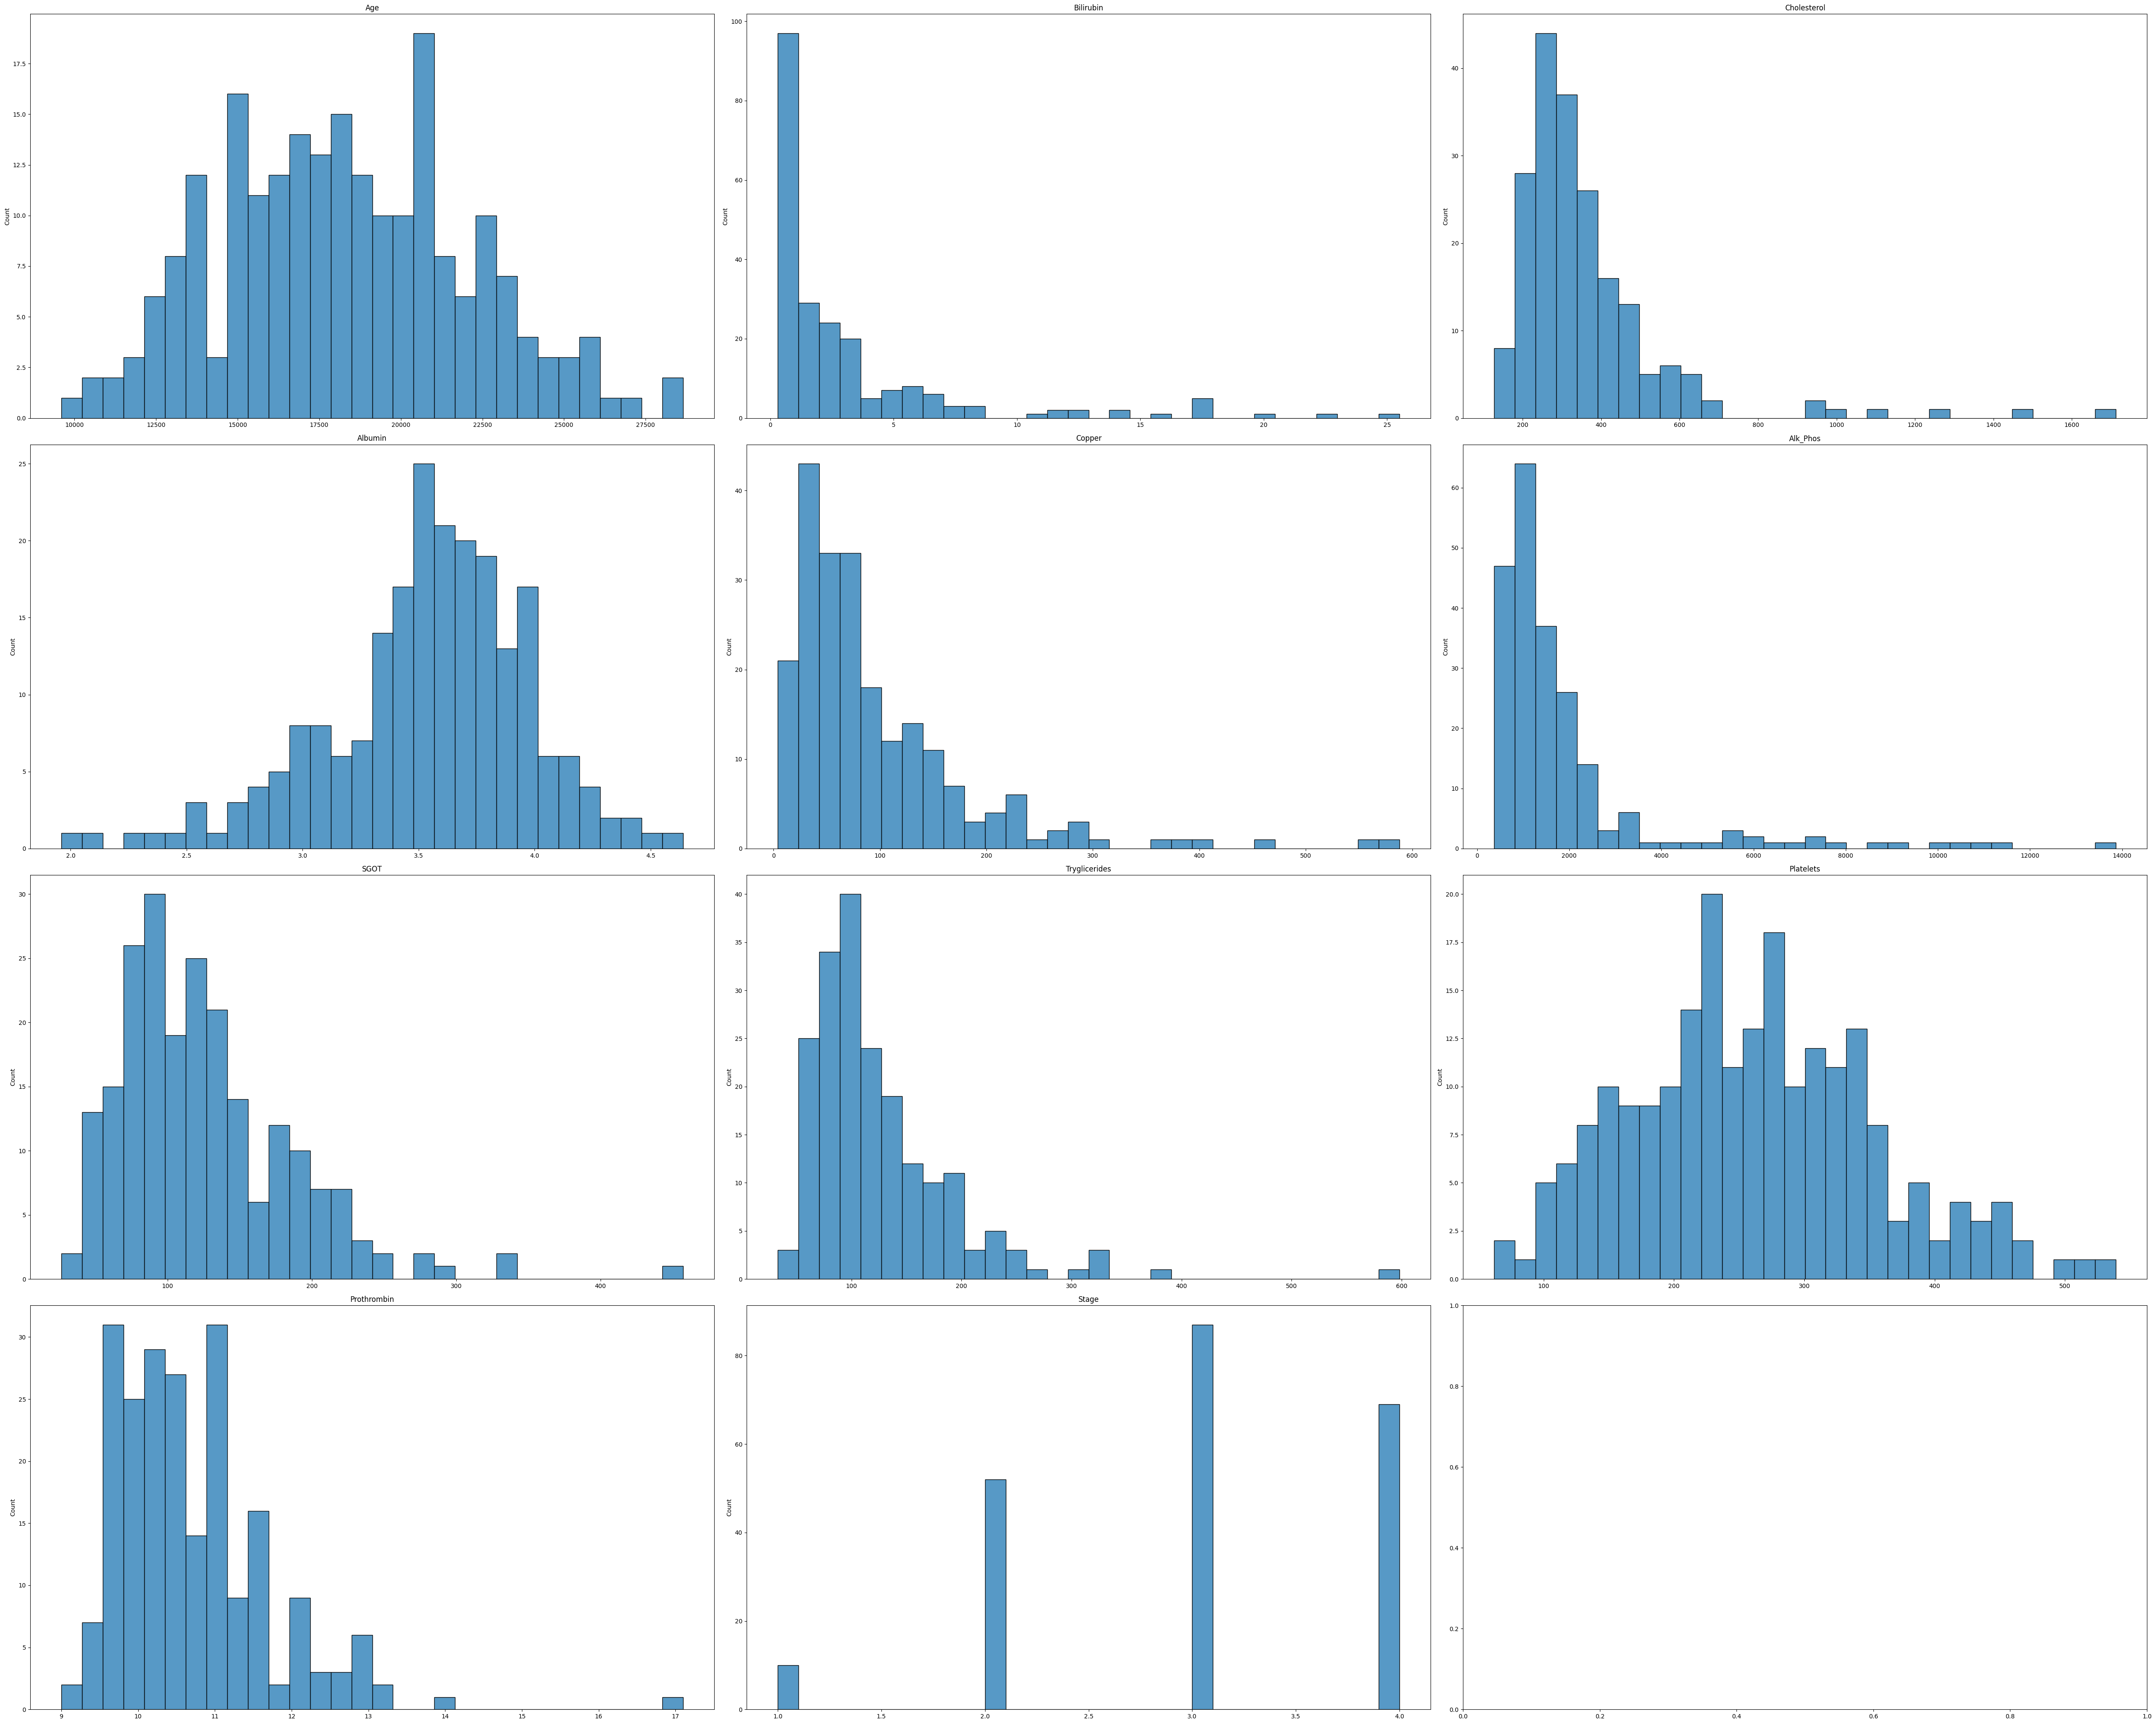

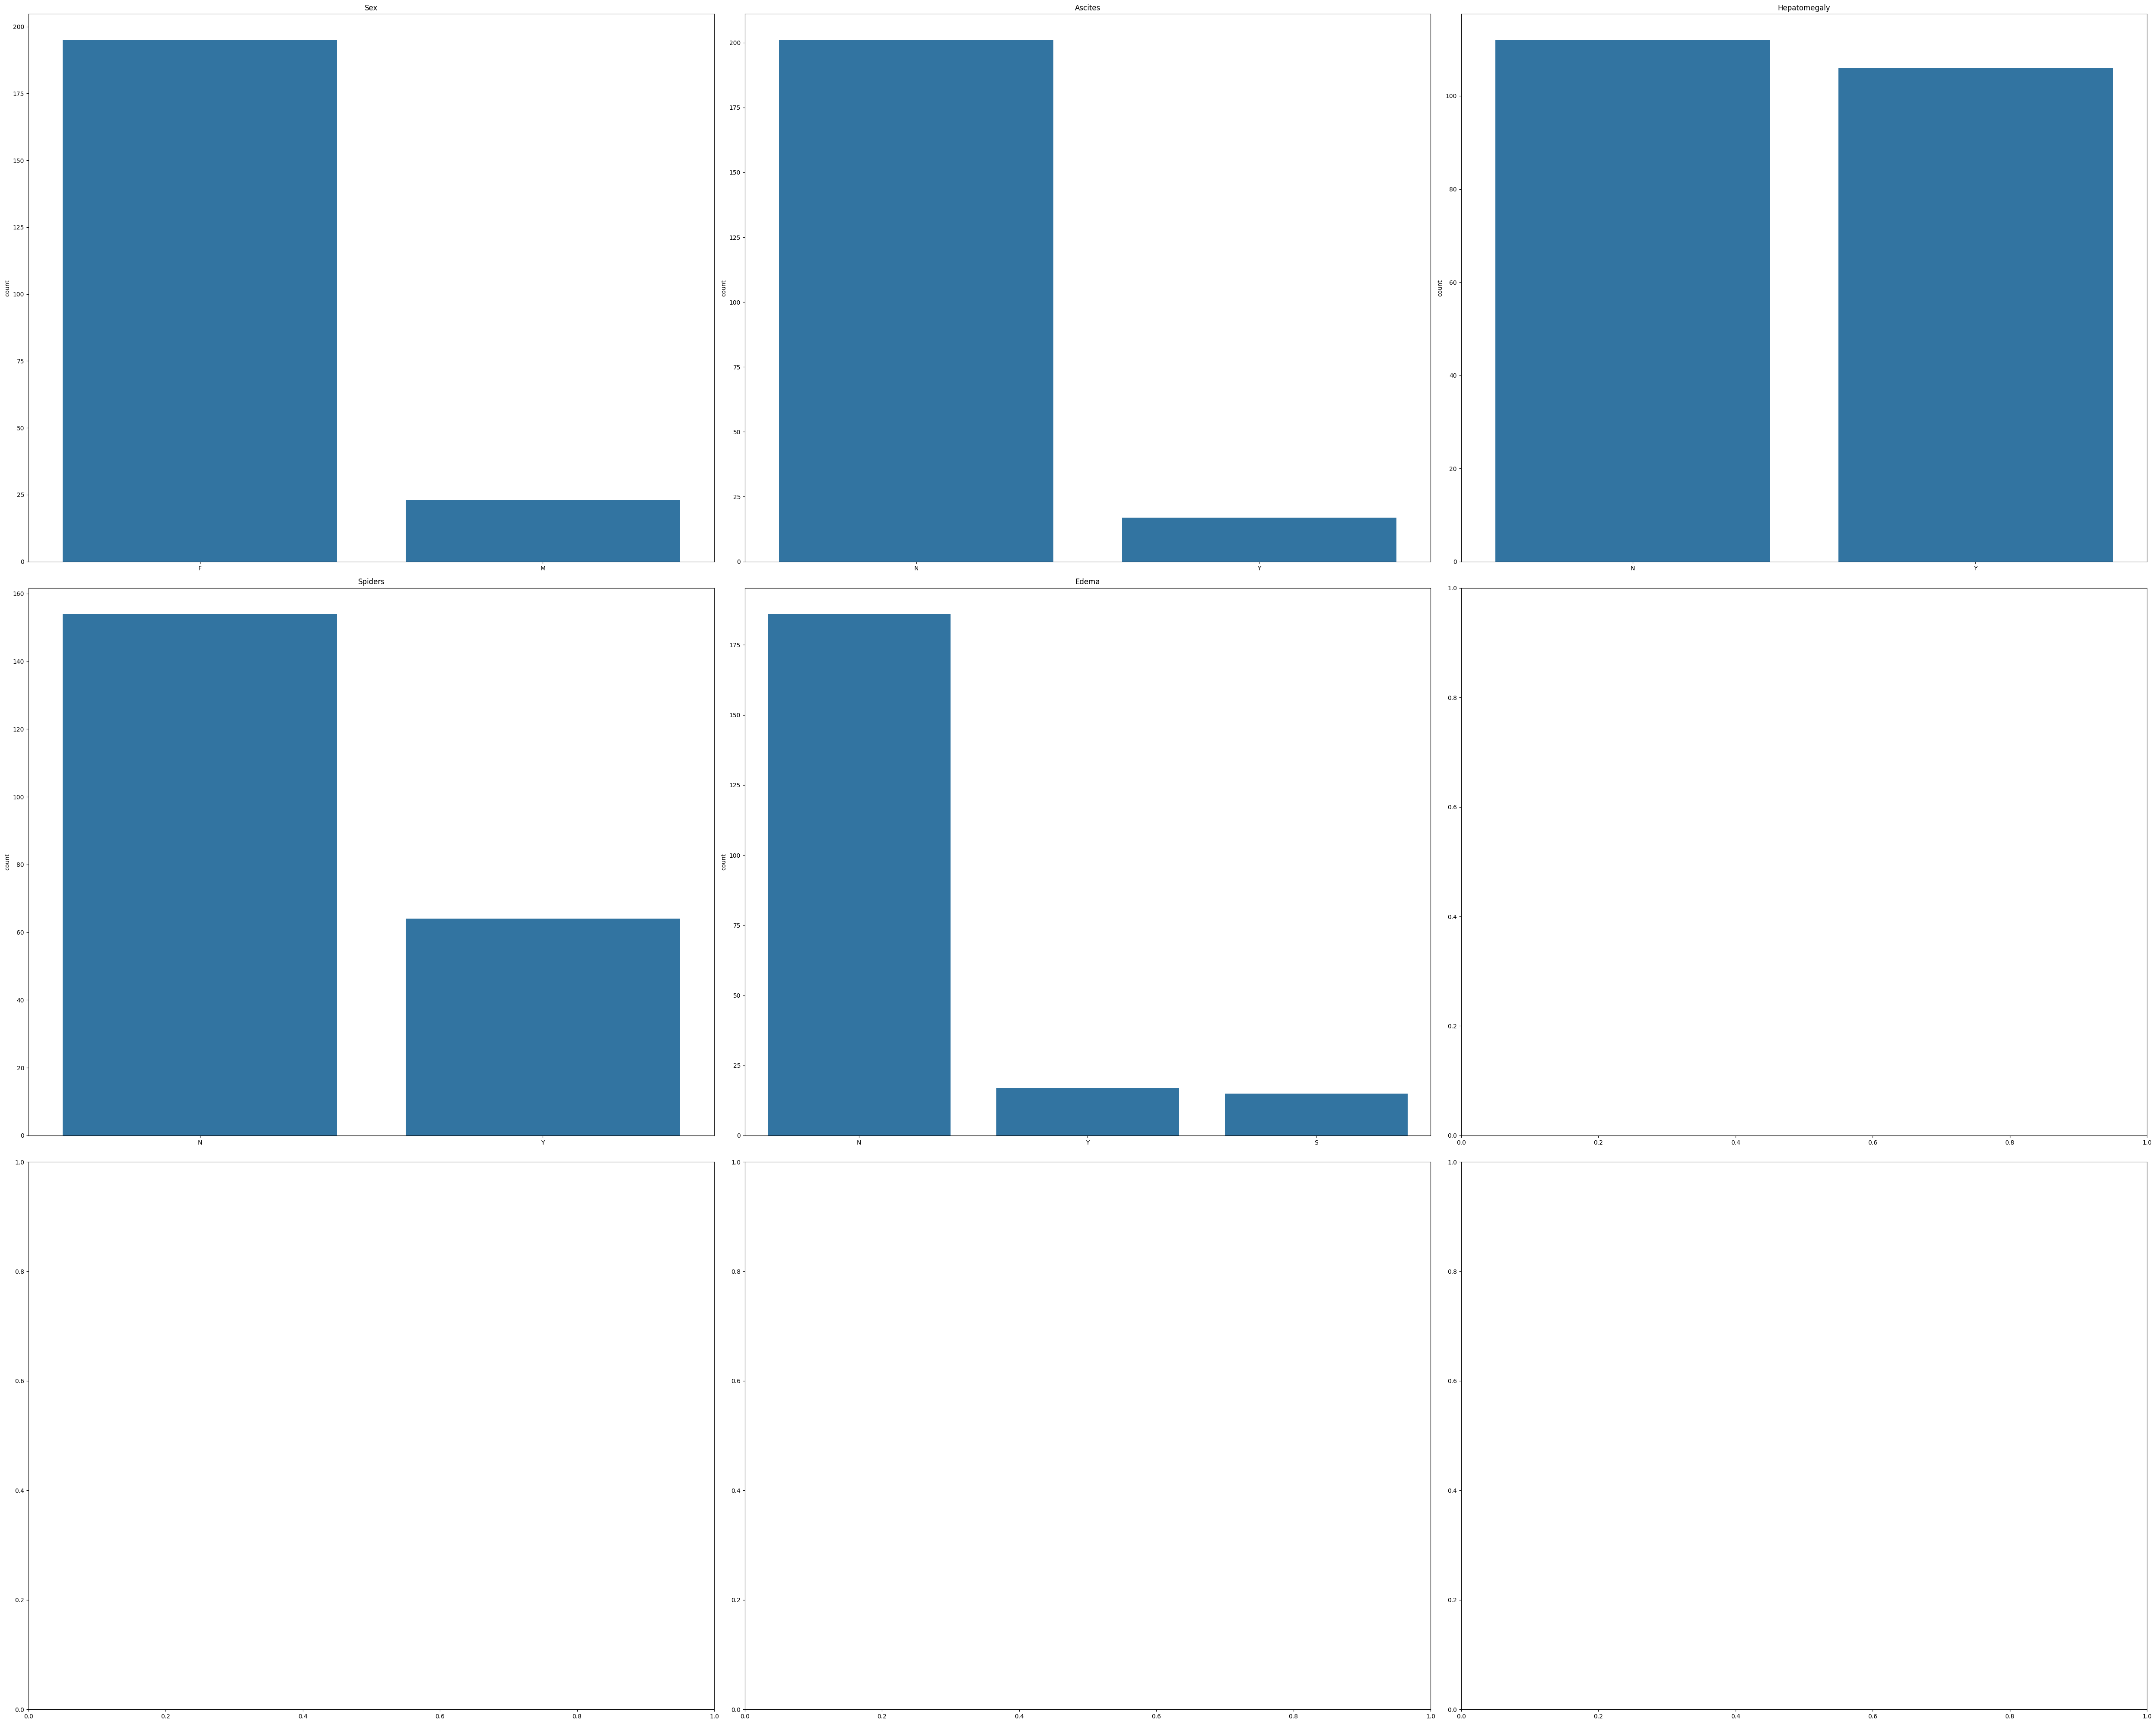

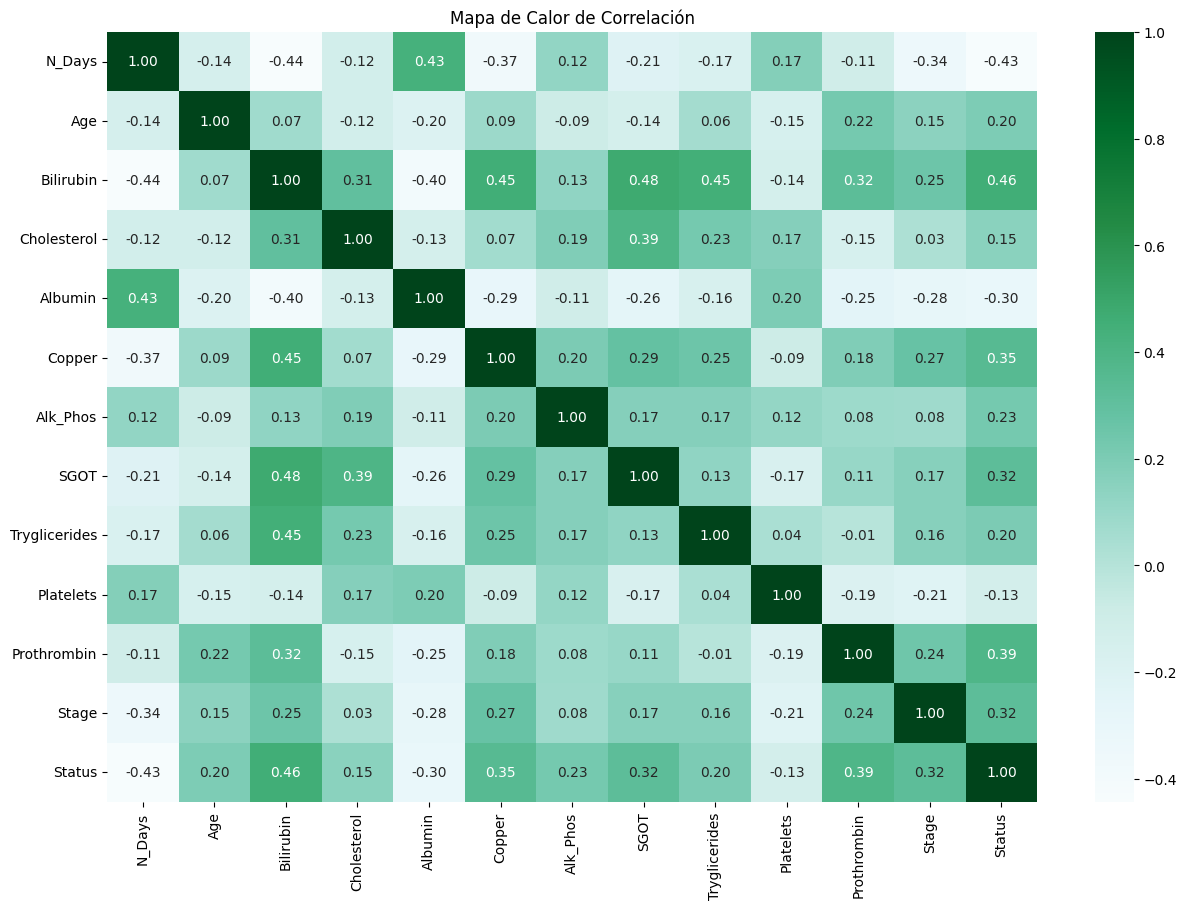

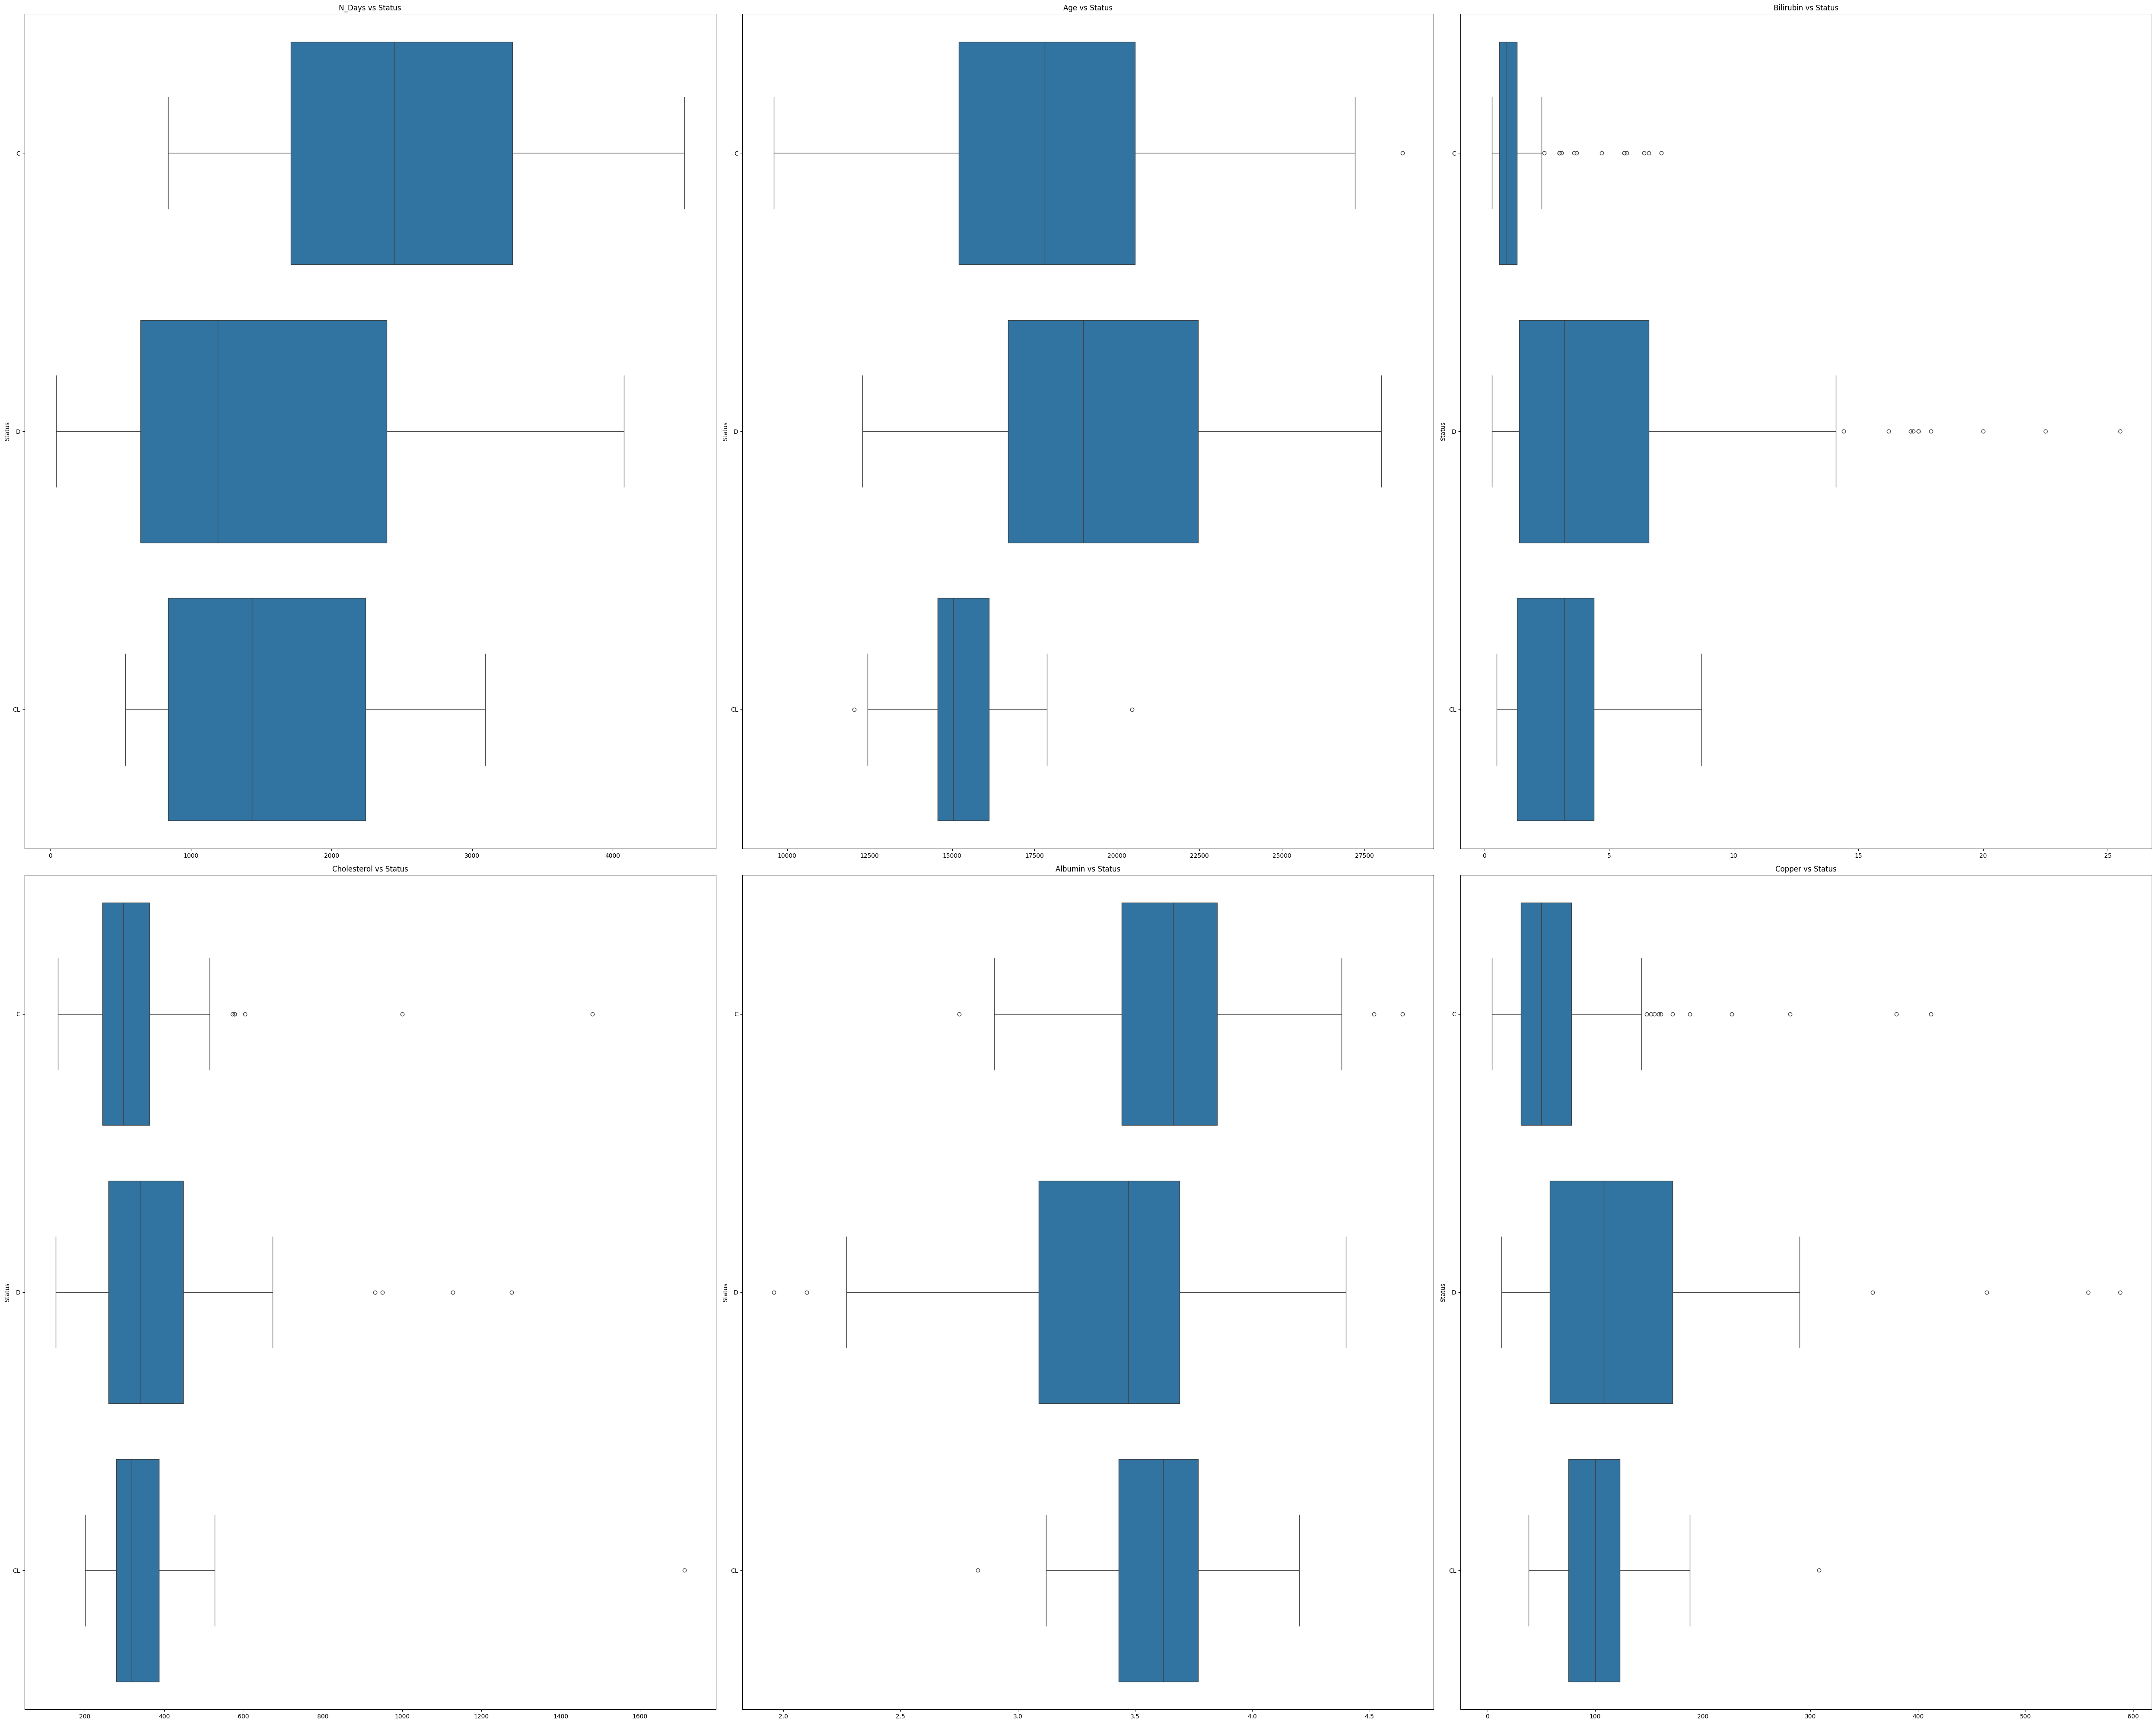

c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\soyel\MLOps\lib\site-packages\sklearn\linear_model\

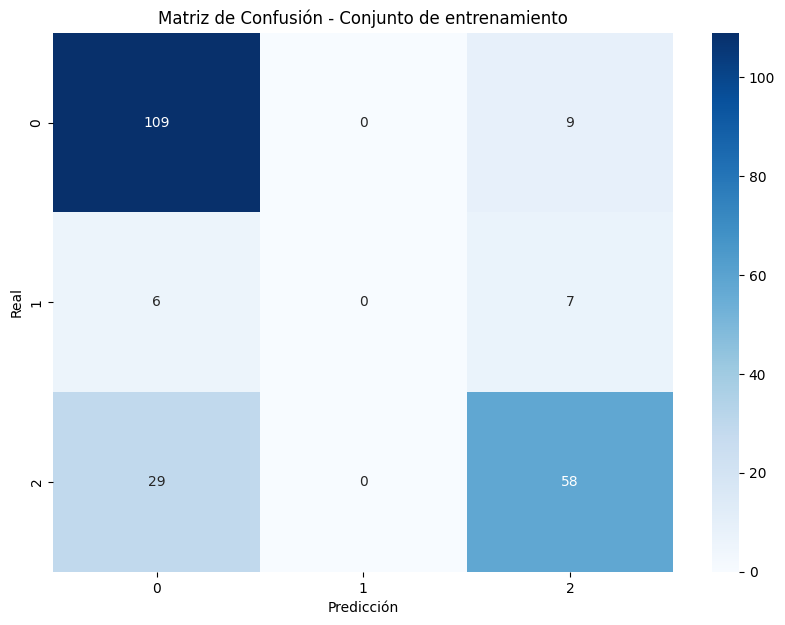

Precisión de conjunto de entrenamiento: 0.72
Recall de conjunto de entrenamiento: 0.77
Puntuación de conjunto de entrenamiento: 0.74
Resultados validacion


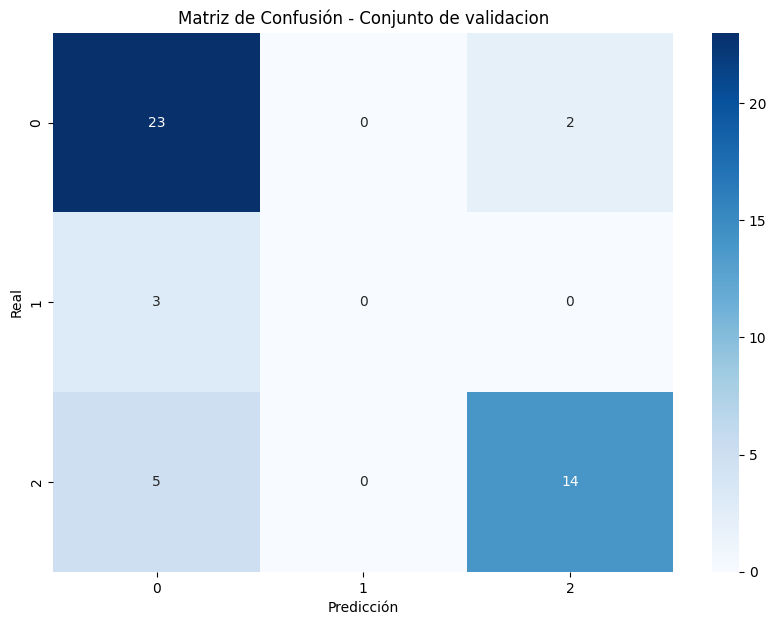

Precisión de conjunto de validacion: 0.75
Recall de conjunto de validacion: 0.79
Puntuación de conjunto de validacion: 0.76


c:\Users\soyel\MLOps\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\soyel\MLOps\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\soyel\MLOps\lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\soyel\MLOps\lib\site-packages\xgboost\core.py:

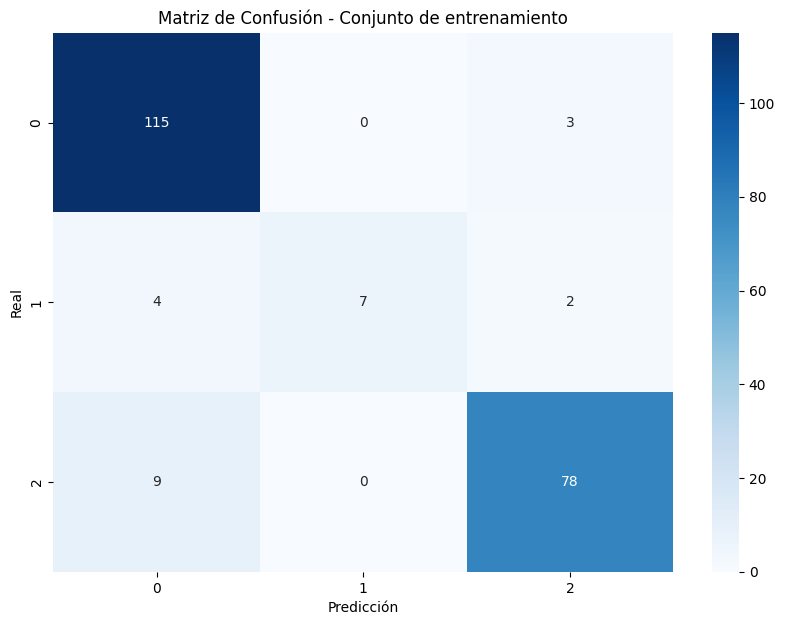

Precisión de conjunto de entrenamiento: 0.92
Recall de conjunto de entrenamiento: 0.92
Puntuación de conjunto de entrenamiento: 0.91
Resultados validacion


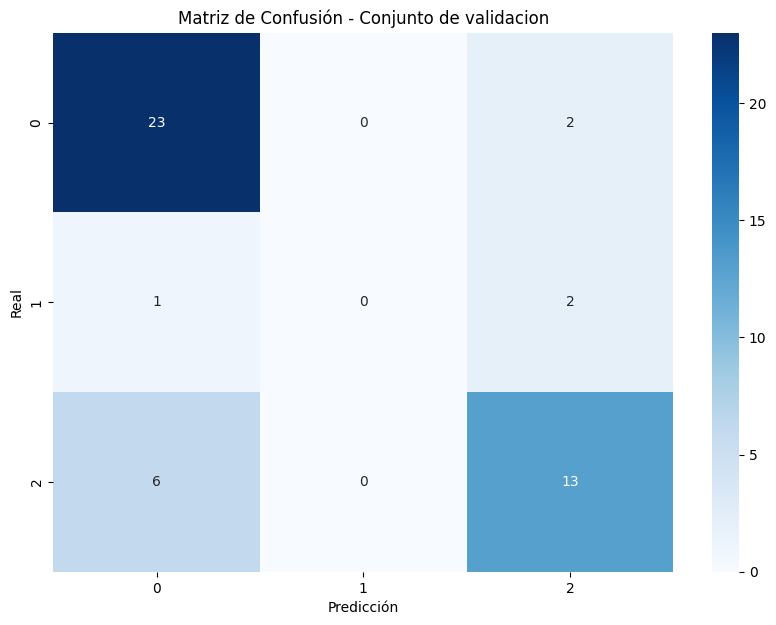

Precisión de conjunto de validacion: 0.72
Recall de conjunto de validacion: 0.77
Puntuación de conjunto de validacion: 0.74


In [142]:
url="https://archive.ics.uci.edu/static/public/878/cirrhosis+patient+survival+prediction+dataset-1.zip"
zippath="../data/cirrhosis.zip"
csvpath="../data"
csvFullpath = "../data/cirrhosis.csv"

#descargarDataDeZipACSV(url=url,zippath=zippath,csvpath=csvpath)
modelos = modelosCIrrhosis(csvFullpath)
modelos.cargar_datos()
modelos.limpiar_datos()
modelos.dividir_datos()
modelos.modelos()